In [1]:
import logging 
import pandas as pd

from pipeline import start_pipeline, set_types_names, filter_outliers, add_categorical_features, normalise_features
logging.basicConfig(level=logging.DEBUG)

In this notebook we'll do a basic introduction to the dataset. We'll demonstrate some code as well as some initial finding.

In [2]:
df = pd.read_csv("data/survey_results_public.csv")

## Processing 

We'll zoom in first just a subset of the data; the developers in the united states. This keeps things simple for now because we don't need to worry about differences in currencies. We'll also first look at the male-female gender bias. To keep this notebook clean we've moved the preprocessing code to a seperate python file called `pipeline.py`. We're using [pandas pipelines](https://tomaugspurger.github.io/method-chaining) to handle the gruntwork (if you're unfamiliar with this pattern you can find a tutorial [here](https://calmcode.io/pandas-pipe/introduction.html)).

In [3]:
clean_df = (df
 .pipe(start_pipeline)
 .pipe(set_types_names)
 .loc[lambda d: d['country'] == 'United States']
 .pipe(filter_outliers)
 .pipe(add_categorical_features)
 .pipe(normalise_features))

INFO:pipeline:[start_pipeline(df)] n_obs=88883 n_col=85 time=0:00:00.044320
INFO:pipeline:[set_types_names(df)] n_obs=88883 n_col=9 time=0:00:00.008242
INFO:pipeline:[filter_outliers(df)] n_obs=13166 n_col=9 time=0:00:00.004859
/Users/vincent/Development/salary-bias/venv/lib/python3.6/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
INFO:pipeline:[split_column(df, datacol = 'languageworkedwith')] n_obs=13166 n_col=38 time=0:00:00.414086
INFO:pipeline:[split_column(df, datacol = 'devtype', prefix = 'devtype')] n_obs=13166 n_col=63 time=0:00:00.341635
INFO:pipeline:[split_column(df, datacol = 'ethnicity', prefix = 'ethnicity')] n_obs=13166 n_col=73 time=0:00:00.171998
INFO:pipeline:[add_categorical_features(df)] n_obs=13166 n_col=70 time=0:00:00.955004
INFO:pipeline:[normalise_features(df)] n_obs=13166 n_col=70 time=0:00:00.027270


Given that we now have a clean dataset, let's do a primaryy check. Can we measure a difference in salary without compensating for skillset, age or experience?

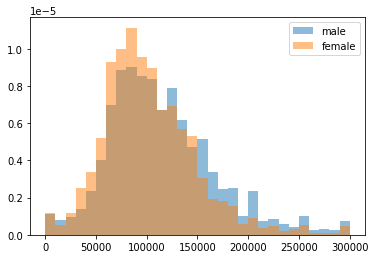

In [6]:
import matplotlib.pylab as plt

male_salary = clean_df.loc[lambda d: d['gender'] == 'Man']['convertedcomp']
female_salary = clean_df.loc[lambda d: d['gender'] == 'Woman']['convertedcomp']

plt.hist(male_salary, bins=30, density=True, alpha=0.5, label="male")
plt.hist(female_salary, bins=30, density=True, alpha=0.5, label="female")
plt.legend();

In [7]:
clean_df.groupby('gender').agg(salary = ('convertedcomp', 'mean'), n = ('convertedcomp', 'size'))

,salary,n
gender,,
Man,113143.699224,11344
Non-Binary,109210.627329,483
Woman,100506.286781,1339


Just looking at this table as well as the graph we should notice a few things; 

1. There is most certainly a difference in salary. Women seem to earn 88% of what men earn. 
2. Women (as well as Non-Binary) are less less frequent in the dataset. This is something to keep in mind with our analyses later on. Bias is one theme but so is imbalance.
3. We're not correcting for anything yet. It may be that we women in our dataset are, in general, younger and this might explain part of the bias. We should correct for variables like age to get a more precise bias-measurement.